### Anomaly detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio

In [98]:
train_data = scio.loadmat("./ex8data1.mat")
print(train_data.keys())
X = train_data['X']
Xval = train_data['Xval']
yval = train_data['yval']
print(X.shape)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])
(307, 2)


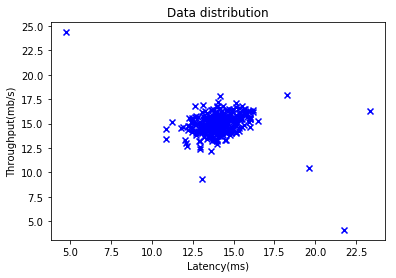

In [99]:
fig = plt.figure()  
ax1 = fig.add_subplot(1, 1, 1)  

ax1.set_title('Data distribution')  
plt.xlabel('Latency(ms)')   
plt.ylabel('Throughput(mb/s)') 

plt.scatter(X[:,0], X[:,1], color='blue', marker='x')

plt.show()

In [120]:
def guassian(X, mean, var):
    p = np.exp(-(X - mean) ** 2 / (2 * var) ) / (np.sqrt(2 * np.pi * var))
    return np.multiply.reduce(p, axis=1)

# Estimate the parameters
mean = np.mean(X, axis=0)
var = np.var(X, axis=0)


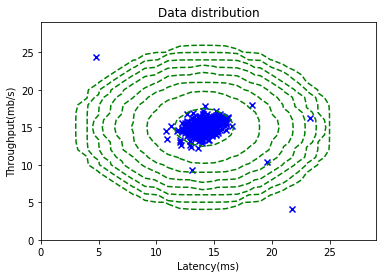

In [101]:
# Plot the contour graph
fig = plt.figure()  
ax1 = fig.add_subplot(1, 1, 1)  

x1 = np.arange(0, 30)
x2 = np.arange(0, 30)
xx1, xx2 = np.meshgrid(x1, x2)
p = guassian(np.c_[xx1.ravel(), xx2.ravel()], mean, var)
# print(p[:10])
ax1.set_title('Data distribution')  
plt.xlabel('Latency(ms)')   
plt.ylabel('Throughput(mb/s)') 

plt.scatter(X[:,0], X[:,1], color='blue', marker='x')
contour = plt.contour(xx1, xx2, p.reshape(xx1.shape[0], xx2.shape[0]), np.logspace(-15,2,10), 
                      colors='green', linestyles='dashed')
# plt.clabel(contour, inline=1, fontsize=10)

plt.show()

In [156]:
# Try different threshold and return the one with max f1 score 
def select_threshold(y, p):
    max_f1 = 0
    max_e = 0
    for e in np.arange(np.min(p), np.max(p), (np.max(p) - np.min(p)) / 1000):
        predict = np.array([1 if item < e else 0 for item in p])
#         print(p)
        f1 = get_f1_score(predict, y)
#         print(f1)
        if f1 > max_f1:
            max_f1 = f1
            max_e = e
    return max_e, max_f1
        
def get_f1_score(y, labels):
    # True positive
    tp = np.sum(y[labels == 1])
    # False positive
    fp = np.sum(y[labels == 0])
    # False negative
    fn = len(y[labels == 1]) - np.sum(y[labels == 1])
    if (tp + fp) == 0:
        precision = 0
    else:
        precision = float(tp) / (tp + fp)
    if (tp + fn) == 0:
        recall = 0
    else:
        recall = float(tp) / (tp + fn)
    if (precision + recall) == 0:
        return 0
    return 2 * precision * recall / (precision + recall)

pval = guassian(Xval, mean, var)
print(select_threshold(yval.ravel(), pval.ravel()))

(8.990852779269493e-05, 0.8750000000000001)


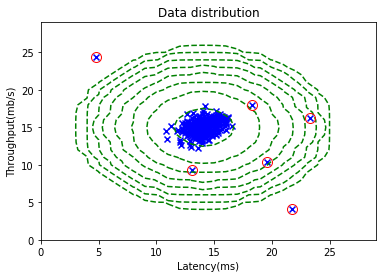

In [157]:
epsilon, _ = select_threshold(yval.ravel(), pval.ravel())
p = guassian(X, mean, var)
# Anomaly points are those with probablity < threshold
anomaly = X[p < epsilon]

fig = plt.figure()  
ax1 = fig.add_subplot(1, 1, 1)  

x1 = np.arange(0, 30)
x2 = np.arange(0, 30)
xx1, xx2 = np.meshgrid(x1, x2)
p = guassian(np.c_[xx1.ravel(), xx2.ravel()], mean, var)
# print(p[:10])
ax1.set_title('Data distribution')
plt.xlabel('Latency(ms)')   
plt.ylabel('Throughput(mb/s)') 

plt.scatter(X[:,0], X[:,1], color='blue', marker='x')
contour = plt.contour(xx1, xx2, p.reshape(xx1.shape[0], xx2.shape[0]), np.logspace(-15,2,10), 
                      colors='green', linestyles='dashed')
# Plot the anomaly points
plt.plot(anomaly[:,0], anomaly[:,1], 'ro', markersize=10, fillstyle='none')
plt.show()

In [ ]:
### Try higher dimention data

In [159]:
train_data = scio.loadmat("./ex8data2.mat")
print(train_data.keys())
X2 = train_data['X']
X2val = train_data['Xval']
y2val = train_data['yval']
print(X2.shape, X2val.shape, y2val.shape)


dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])
(1000, 11) (100, 11) (100, 1)


In [179]:
def gaussian_multiple(X, mu, sigma):
    num_feat = X.shape[1]
    over = np.exp(-(X - mu).dot(np.linalg.inv(sigma)).dot((X - mu).T) / 2)
    under = (np.sqrt((2 * np.pi)**num_feat * np.linalg.det(sigma)))
    return over / under

mean = np.mean(X2, axis=0)
# print(mean)
# sigma = (X2 - mean).T.dot(X2 - mean) / len(X2)
# Use variance, so actually we hypothesize the features are independent
sigma = np.diag(np.var(X2, axis=0))
# print(sigma)
# print(np.linalg.det(sigma))

p2 = np.array([gaussian_multiple(x.reshape(1, -1), mean, sigma) for x in X2])
p2val = np.array([gaussian_multiple(x.reshape(1, -1), mean, sigma) for x in X2val])
# print(p2val[:3])

epsilon, _ = select_threshold(y2val.ravel(), p2val.ravel())
print(epsilon)
print(np.sum(p2 < epsilon))
print(np.sum(p2val < epsilon))

1.3772288907613575e-18
117
16
